In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
# import parser_arguments
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch
import scipy.stats as stats
from math import ceil

# Set defaults

In [3]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
# chip_names = ["ET2_W36_IP5_20", "ET2_W36_IP7_13", "ET2_W36_IP5_15", "ET2_CNM_BATCH_2_6"]
chip_names = ["W15_2_3"]
chip_names = ["Pair1"]
# chip_names = ["ET2_PacTech8"]
# chip_names = ["ET2_W36_IP5_20", "ET2_W36_IP5_15"]
chip_fignames = chip_names
chip_figtitles = chip_names

# 'The port name the USB-ISS module is connected to. Default: /dev/ttyACM0'
port = "/dev/ttyACM1"
# I2C addresses for the pixel block and WS
chip_addresses = [0x60] 
# chip_addresses = [0x71, 0x61, 0x74, 0x62]
# chip_addresses = [0x71, 0x61, 0x62]
ws_addresses = [0x40]

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# Make i2c_connection class object

In [5]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
# i2c_conn = i2c_connection(port,chip_addresses,chip_names,[("1","1"),("1","1"),("1","1")])
i2c_conn = i2c_connection(port,chip_addresses,ws_addresses,chip_names,[("1","1"),("1","1"),("1","1")])

# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [6]:
# (WS Prep Pixel and Peri) - 0 - (disable & auto_cal all pixels) - (disable default all pixels) - (auto_TH_CAL) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00100111')
# i2c_conn.config_chips('00001111') # disable and more fun things
# i2c_conn.config_chips('00000100') # set basic peripherals
# i2c_conn.config_chips('00010000') # calibrate only
# i2c_conn.config_chips('00000001') # pixel ID check (I2C check)
# i2c_conn.config_chips('10000000') # ws init
# i2c_conn.disable_all_pixels(chip_address=chip_addresses[1])

Passed pixel check for chip: 0x60
Passed peripheral write check for chip: 0x60
Peripherals set for chip: 0x60
Disabled pixels for chip: 0x60


Calibrating row: 100%|██████████| 16/16 [01:31<00:00,  5.73s/it]

Auto calibration finished for chip: 0x60


## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [7]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

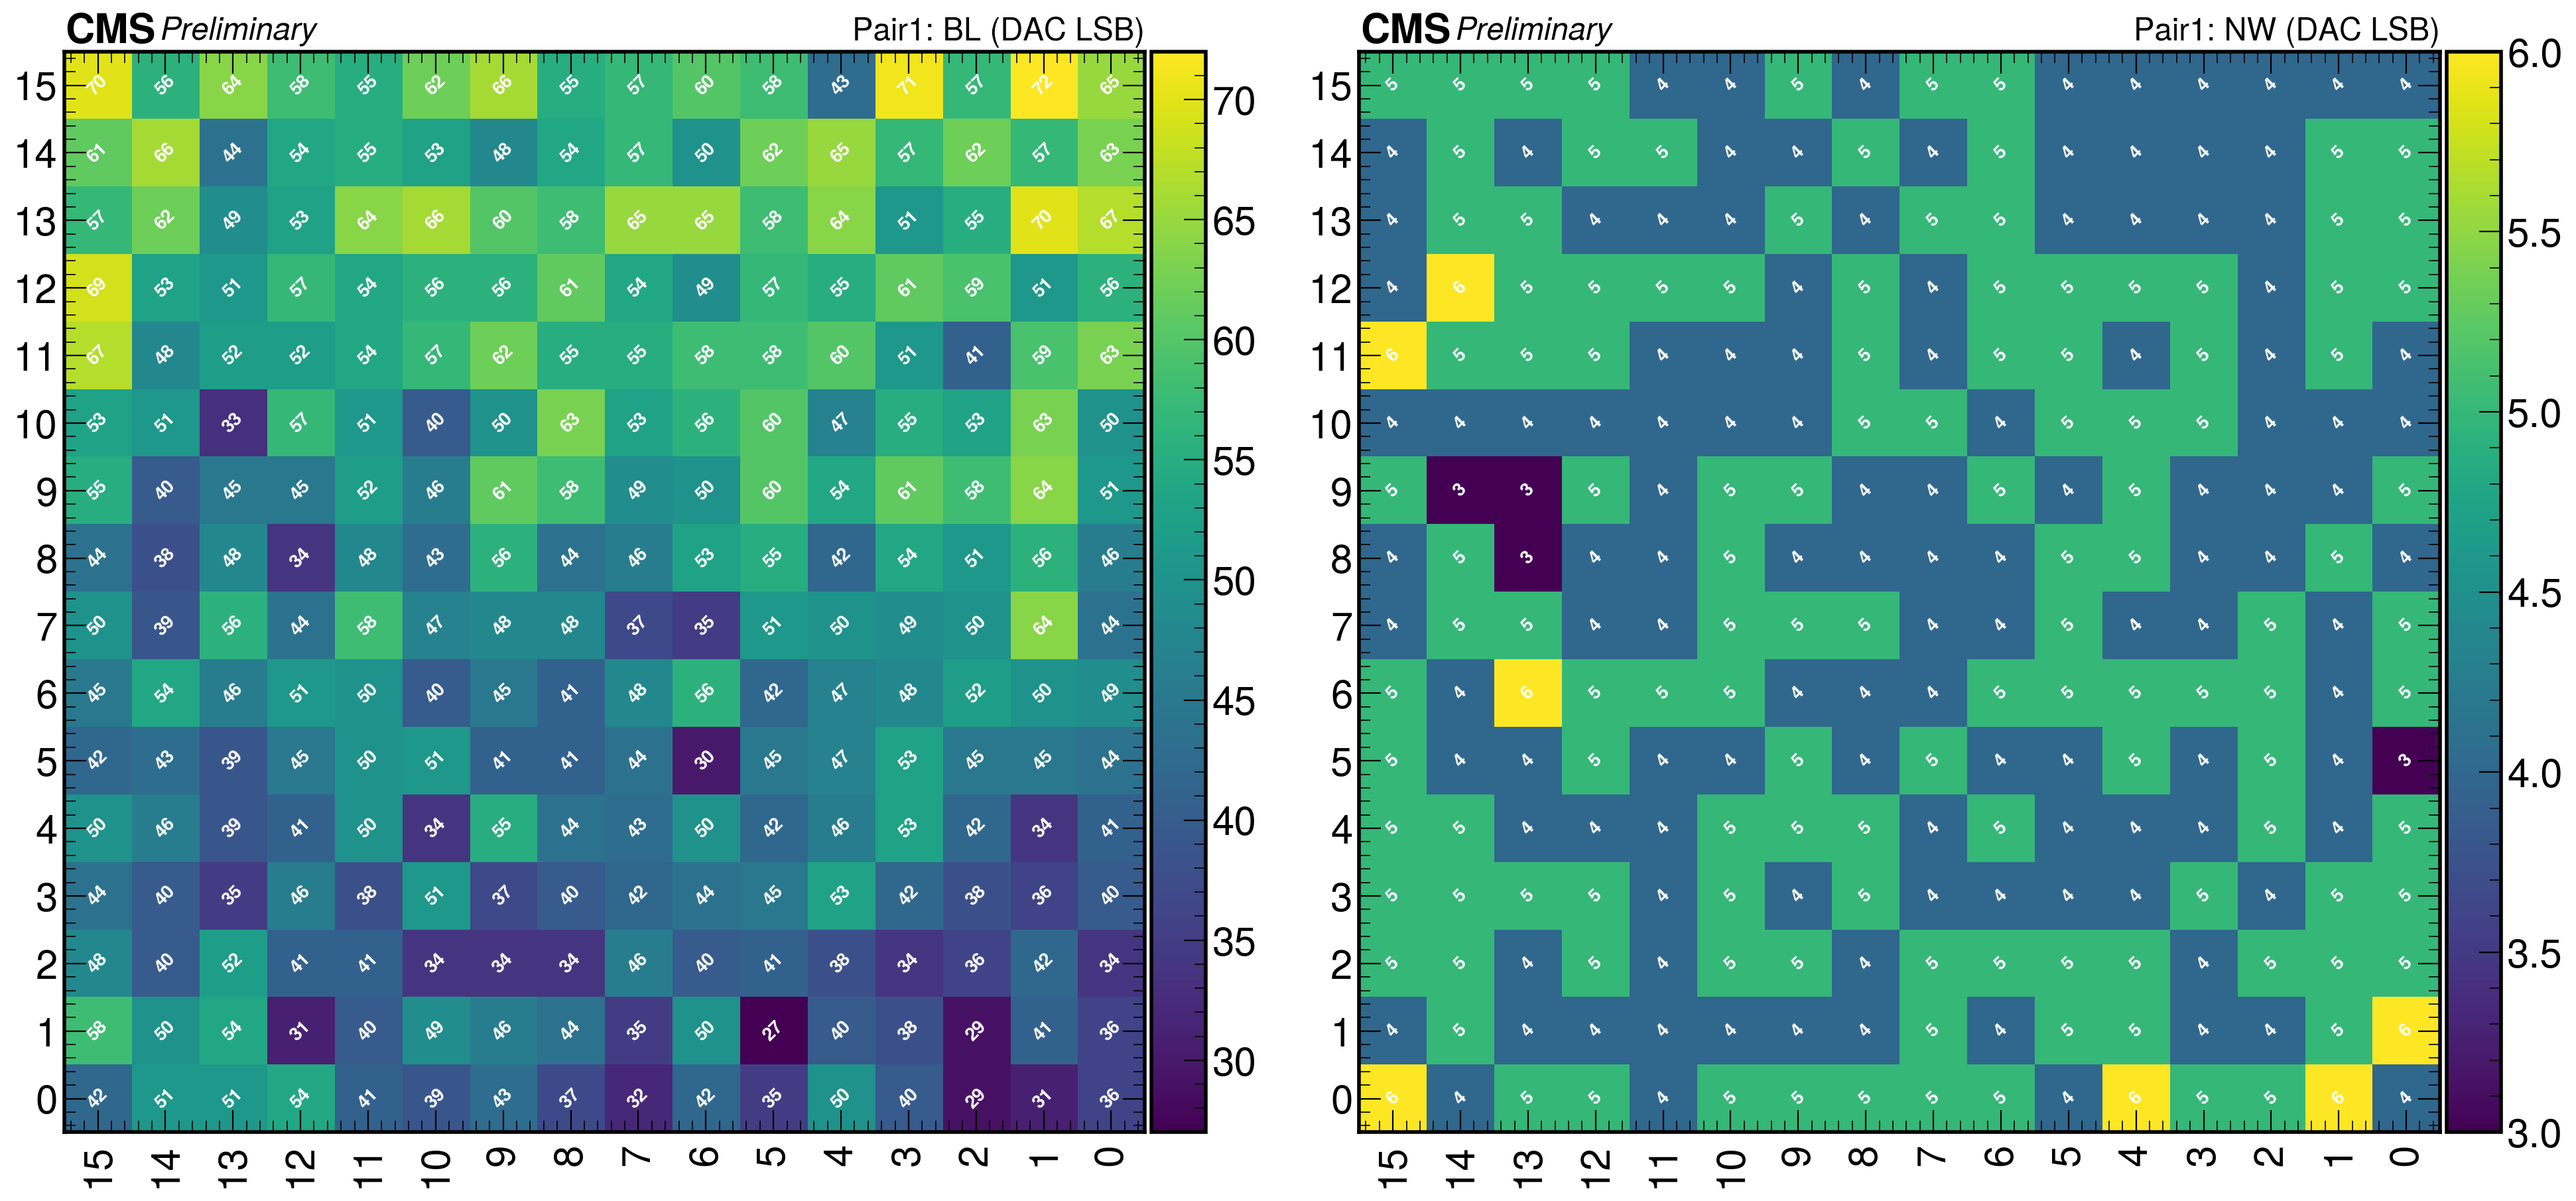

In [8]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_figtitles):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(20,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.show()

In [8]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.save_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.save_auto_cal_NW_map(chip_address, chip_name, "")

In [ ]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.load_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.load_auto_cal_NW_map(chip_address, chip_name, "")

# Define pixels of interest

In [9]:
# row_list = [15, 15, 15, 15]
col_list = [6, 7, 8, 9]
row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]
# row_list = [9, 3, 12]
# col_list = [3, 8, 11]
# row_list = [15, 15]
# col_list = [6, 9]
# row_list = [14, 14, 15, 15]
# col_list = [6, 9, 6, 9]
row_list = [14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15]
col_list = [6, 7, 8, 9, 6, 7, 8, 9, 11, 12, 13]
# col_list = np.arange(16)
# row_list = np.full_like(col_list,12)
# row_list = np.full_like(col_list,13)
# col_list = [10, 13, 7, 4, 10, 13, 7, 4]
# row_list = [12, 12, 12, 12, 13, 13, 13, 13]

scan_list = list(zip(row_list, col_list))

# col_list, row_list = np.meshgrid(np.arange(16),np.arange(16))
# scan_list = list(zip(row_list.flatten(),col_list.flatten()))

print(scan_list)

[(14, 6), (14, 7), (14, 8), (14, 9), (15, 6), (15, 7), (15, 8), (15, 9), (15, 11), (15, 12), (15, 13)]


In [ ]:
row_list = [15, 15, 15, 15]
col_list = [6, 7, 8, 9]

scan_list = list(zip(row_list, col_list))
print(scan_list)

### Enable pixels of Interest

In [10]:
# i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn=True,Bypass_THCal=False,specified_addresses=chip_addresses[:], power_mode="low")
i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn=True,Bypass_THCal=False)

Enabled pixel (14,6) for chip: 0x60
Enabled pixel (14,7) for chip: 0x60
Enabled pixel (14,8) for chip: 0x60
Enabled pixel (14,9) for chip: 0x60
Enabled pixel (15,6) for chip: 0x60
Enabled pixel (15,7) for chip: 0x60
Enabled pixel (15,8) for chip: 0x60
Enabled pixel (15,9) for chip: 0x60
Enabled pixel (15,11) for chip: 0x60
Enabled pixel (15,12) for chip: 0x60
Enabled pixel (15,13) for chip: 0x60


In [11]:
offset = 0x0a
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # i2c_conn.pixel_decoded_register_write("QSel", format(0x1e, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
        # i2c_conn.pixel_decoded_register_write("QInjEn", "1", chip)
        # i2c_conn.pixel_decoded_register_write("enable_TDC", "1", chip)
    del chip, row_indexer_handle, column_indexer_handle

Operating on chip 0x60 Pixel (14,6)
Operating on chip 0x60 Pixel (14,7)
Operating on chip 0x60 Pixel (14,8)
Operating on chip 0x60 Pixel (14,9)
Operating on chip 0x60 Pixel (15,6)
Operating on chip 0x60 Pixel (15,7)
Operating on chip 0x60 Pixel (15,8)
Operating on chip 0x60 Pixel (15,9)
Operating on chip 0x60 Pixel (15,11)
Operating on chip 0x60 Pixel (15,12)
Operating on chip 0x60 Pixel (15,13)


In [17]:
register_names = ["enable_TDC","disDataReadout","QInjEn","disTrigPath", "L1Adelay", "Bypass_THCal", "TH_offset", "QSel", "DAC", "IBSel", "upperTOATrig", "lowerTOATrig", "upperTOTTrig", "lowerTOTTrig", "upperCalTrig", "lowerCalTrig", "upperTOA", "lowerTOA", "upperTOT", "lowerTOT", "upperCal", "lowerCal"]
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        for register in register_names:
            print(register, i2c_conn.pixel_decoded_register_read(register, "Config", chip, need_int=True))
    del chip, row_indexer_handle, column_indexer_handle

Operating on chip 0x60 Pixel (14,6)
enable_TDC 1
disDataReadout 0
QInjEn 1
disTrigPath 0
L1Adelay 501
Bypass_THCal 0
TH_offset 10
QSel 27
DAC 1023
IBSel 7
upperTOATrig 1023
lowerTOATrig 0
upperTOTTrig 511
lowerTOTTrig 0
upperCalTrig 1023
lowerCalTrig 0
upperTOA 1023
lowerTOA 0
upperTOT 511
lowerTOT 0
upperCal 1023
lowerCal 0
Operating on chip 0x60 Pixel (14,7)
enable_TDC 1
disDataReadout 0
QInjEn 1
disTrigPath 0
L1Adelay 501
Bypass_THCal 0
TH_offset 10
QSel 27
DAC 1023
IBSel 7
upperTOATrig 1023
lowerTOATrig 0
upperTOTTrig 511
lowerTOTTrig 0
upperCalTrig 1023
lowerCalTrig 0
upperTOA 1023
lowerTOA 0
upperTOT 511
lowerTOT 0
upperCal 1023
lowerCal 0
Operating on chip 0x60 Pixel (14,8)
enable_TDC 1
disDataReadout 0
QInjEn 1
disTrigPath 0
L1Adelay 501
Bypass_THCal 0
TH_offset 10
QSel 27
DAC 1023
IBSel 7
upperTOATrig 1023
lowerTOATrig 0
upperTOTTrig 511
lowerTOTTrig 0
upperCalTrig 1023
lowerCalTrig 0
upperTOA 1023
lowerTOA 0
upperTOT 511
lowerTOT 0
upperCal 1023
lowerCal 0
Operating on chip 0

In [ ]:
row_list = [14, 14, 14, 14]
col_list = [6, 7, 8, 9]

scan_list = list(zip(row_list, col_list))
print(scan_list)

In [ ]:
i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn=True,Bypass_THCal=False,specified_addresses=chip_addresses[2:3])

In [ ]:
offset = 0x0f
for chip_address in chip_addresses[2:3]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

In [ ]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    i2c_conn.disable_pixel(row=4, col=3, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

# Calibrate FC for all I2C

In [13]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

Reset Global Readout done for chip: 0x60
asyAlignFastcommand action done for chip: 0x60


# Calibrate PLL

In [22]:
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)

PLL Calibrated for chip: 0x61


# Disconnect I2C Device

## DO THIS IF YOU PLAN TO DO NOISE STUDIES

In [ ]:
del i2c_conn